In [1]:
from gurobipy import *
import time
import pandas as pd
from scipy.spatial.distance import euclidean
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = 'customers.txt'
# read text file
with open(path, encoding='utf8') as f:
    lines = f.readlines()
    
rows = []
for line in lines:
    row = line.strip().split('\t')
    rows.append(row)
df = pd.DataFrame(rows, columns = rows[0])
df = df.drop(0)
df = df.set_index('CUST NO.')

first_row = df.iloc[0]
df = pd.concat([df, first_row.to_frame().transpose()], ignore_index=True)
df = df.astype({'X COORD.': 'int', 'Y COORD.': 'int'})
df.head()

,X COORD.,Y COORD.
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [3]:
Ndrones = 2 # Número de drones
k = Ndrones
n = len(df) - 2 # Número de clientes


N = range(1, len(df.index) - 1) # Índice de clientes {1, 2, ..., n}
V = range(len(df.index)) # Índice de clientes y depósito {0, 1, ..., n+1}
S = range(1,Ndrones + 1) # Índice de rutas inicales 


T = 12 # Time limit


# Se crean los arcos del grafo
arcos = []
for i in V:
    for j in V:
        if i != j:
            if i != len(V) - 1 and j != 0:
                arcos.append(tuple((i,j)))
arcos.remove((0, len(df) - 1))



# Se calculan los costos (distancias)

t = {} # Tiempo en minutos
for arc in arcos:
    point1 = df.loc[arc[0], ['X COORD.', 'Y COORD.']].values
    point2 = df.loc[arc[1], ['X COORD.', 'Y COORD.']].values
    distance = euclidean(point1, point2)
    t[arc] = distance
    
    
    
P_ij = {(i,j): t[0,j]**4/max(t.values()) if j != len(df)-1 else 0 for (i,j) in arcos}
c = {(i,j): 1 for (i,j) in arcos}


G = nx.DiGraph()
G.add_edges_from(arcos)

Auxiliary problem maximising only on probability of vulnerability

In [4]:
# Calculates auxiliary's problem cost 
c_q = {(i,j): P_ij[i,j] for (i,j) in arcos}

m = Model('AuxProblem')


# Variables

b = {(i,j): m.addVar(vtype = GRB.BINARY, obj = c_q[i,j], name = 'b' + str(i)+str(j)) for (i,j) in arcos}



start_node = 0
end_node = n+1


# Constraints

# Exit origin node only once
m.addConstr(quicksum(b[start_node, j] for j in N) == 1)

# Enter destination node only once
m.addConstr(quicksum(b[i, end_node] for i in N) == 1)

# Flow constraints
for i in N:
    m.addConstr(quicksum(b[i,j] for j in G.successors(i)) - quicksum(b[j,i] for j in G.predecessors(i)) == 0)


### Chat GPT


# Add binary variable for each node to track whether it is visited in the path
z = {}
for i in G.nodes():
    z[i] = m.addVar(vtype=GRB.BINARY, name='z_{0}'.format(i))    
    
# Add MTZ constraints for each node (except start and end)
M = G.number_of_nodes() + 1
u = {}
for i in G.nodes():
    if i != start_node and i != end_node:
        u[i] = m.addVar(vtype=GRB.CONTINUOUS, name='u_{0}'.format(i))

for i in G.nodes():
    if i != start_node and i != end_node:
        for j in G.nodes():
            if j != start_node and j != end_node and i != j:
                expr = u[i] - u[j] + M * b[i, j] <= M - 1 - M * (1 - z[j])
                m.addConstr(expr)


                
# Resource constraint (time)
m.addConstr(quicksum(t[i,j]*b[i,j] for (i,j) in arcos) <= T)



# Maximise
m.ModelSense = -1


# Model's parameters
m.setParam("OutputFlag", 1) 
m.setParam("DualReductions", 0)
m.setParam("InfUnbdInfo", 1)
m.setParam('Threads', 8)



m.update()
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-18
Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
Set parameter Threads to value 8
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 579 rows, 650 columns and 4008 nonzeros
Model fingerprint: 0x3475424c
Variable types: 24 continuous, 626 integer (626 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 65.4073773
Presolve time: 0.02s
Presolved: 579 rows, 650 columns, 3968 nonzeros
Variable types: 24 continuous, 626 integer (626 binary)

Root relaxation: objective 1.104027e+03, 116 iterations, 0.00 seconds (0.00 work units)

    Nodes

In [5]:
bvals = { k : v.X for k,v in b.items() }

cOF = sum(bvals[i,j] * c[i,j] for (i,j) in arcos)
POF = sum(bvals[i,j] * P_ij[i,j] for (i,j) in arcos)



min_c_OF = cOF
max_p_OF = POF

print('When only P_ij is considered in the OF, cost:', cOF,'and probability', POF)

When only P_ij is considered in the OF, cost: 4.0 and probability 401.99020510455233


In [6]:
for (i,j) in bvals:
    if bvals[i,j] > 0.5:
        print(i,j)

0 19
19 24
23 25
24 23


Auxiliary problem maximising only on node coverage

In [7]:
# Calculates auxiliary's problem cost 
c_q = {(i,j): c[i,j] for (i,j) in arcos}

m = Model('AuxProblem')


# Variables

b = {(i,j): m.addVar(vtype = GRB.BINARY, obj = c_q[i,j], name = 'b' + str(i)+str(j)) for (i,j) in arcos}


start_node = 0
end_node = n+1


# Constraints

# Exit origin node only once
m.addConstr(quicksum(b[start_node, j] for j in N) == 1)

# Enter destination node only once
m.addConstr(quicksum(b[i, end_node] for i in N) == 1)

# Flow constraints
for i in N:
    m.addConstr(quicksum(b[i,j] for j in G.successors(i)) - quicksum(b[j,i] for j in G.predecessors(i)) == 0)


### Chat GPT


# Add binary variable for each node to track whether it is visited in the path
z = {}
for i in G.nodes():
    z[i] = m.addVar(vtype=GRB.BINARY, name='z_{0}'.format(i))    
    
# Add MTZ constraints for each node (except start and end)
M = G.number_of_nodes() + 1
u = {}
for i in G.nodes():
    if i != start_node and i != end_node:
        u[i] = m.addVar(vtype=GRB.CONTINUOUS, name='u_{0}'.format(i))

for i in G.nodes():
    if i != start_node and i != end_node:
        for j in G.nodes():
            if j != start_node and j != end_node and i != j:
                expr = u[i] - u[j] + M * b[i, j] <= M - 1 - M * (1 - z[j])
                m.addConstr(expr)


                
# Resource constraint (time)
m.addConstr(quicksum(t[i,j]*b[i,j] for (i,j) in arcos) <= T)



# Maximise
m.ModelSense = -1


# Model's parameters
m.setParam("OutputFlag", 1) 
m.setParam("DualReductions", 0)
m.setParam("InfUnbdInfo", 1)
m.setParam('Threads', 8)


m.update()
m.optimize()

Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
Set parameter Threads to value 8
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 579 rows, 650 columns and 4008 nonzeros
Model fingerprint: 0x07e2808c
Variable types: 24 continuous, 626 integer (626 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 3.0000000
Presolve time: 0.03s
Presolved: 579 rows, 650 columns, 3968 nonzeros
Variable types: 24 continuous, 626 integer (626 binary)

Root relaxation: objective 1.200000e+01, 154 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

In [8]:
bvals = { k : v.X for k,v in b.items() }

cOF = sum(bvals[i,j] * c[i,j] for (i,j) in arcos)
POF = sum(bvals[i,j] * P_ij[i,j] for (i,j) in arcos)



max_c_OF = cOF
min_p_OF = POF

print('When only c_ij is considered in the OF, cost:', cOF,'and probability', POF)

When only c_ij is considered in the OF, cost: 12.0 and probability 205.41451993469204


In [9]:
for (i,j) in bvals:
    if bvals[i,j] > 0.5:
        print(i,j)

0 1
1 2
2 7
5 25
7 12
10 5
12 17
15 10
16 15
17 22
21 16
22 21


### Pareto front procedure

Iterative process of reoptimising 

In [10]:
beta = 10e-6
rango = max_p_OF - min_p_OF

OFc = []
OFp = []

OF_p_min = min_p_OF

In [11]:
# Calculates auxiliary's problem cost using dual variables of the relaxed master problem
c_q = {(i,j): c[i,j] for (i,j) in arcos}
iter_n = 0


while OF_p_min < max_p_OF:
    
    
    iter_n += 1
    m = Model('AuxProblem: '+str(iter_n))


    # Variables

    b = {(i,j): m.addVar(vtype = GRB.BINARY, obj = c_q[i,j], name = 'b' + str(i)+str(j)) for (i,j) in arcos}
    slack = m.addVar(vtype = GRB.CONTINUOUS, obj = beta/rango)


    start_node = 0
    end_node = n+1



    ### New constraint

    delta = 0.001
    eta = OF_p_min + delta
    m.addConstr(quicksum(b[i,j] * P_ij[i,j] for (i,j) in arcos) - slack == eta)




    # Constraints

    # Exit origin node only once
    m.addConstr(quicksum(b[start_node, j] for j in N) == 1)

    # Enter destination node only once
    m.addConstr(quicksum(b[i, end_node] for i in N) == 1)

    # Flow constraints
    for i in N:
        m.addConstr(quicksum(b[i,j] for j in G.successors(i)) - quicksum(b[j,i] for j in G.predecessors(i)) == 0)


    ### Chat GPT


    # Add binary variable for each node to track whether it is visited in the path
    z = {}
    for i in G.nodes():
        z[i] = m.addVar(vtype=GRB.BINARY, name='z_{0}'.format(i))    

    # Add MTZ constraints for each node (except start and end)
    M = G.number_of_nodes() + 1
    u = {}
    for i in G.nodes():
        if i != start_node and i != end_node:
            u[i] = m.addVar(vtype=GRB.CONTINUOUS, name='u_{0}'.format(i))

    for i in G.nodes():
        if i != start_node and i != end_node:
            for j in G.nodes():
                if j != start_node and j != end_node and i != j:
                    expr = u[i] - u[j] + M * b[i, j] <= M - 1 - M * (1 - z[j])
                    m.addConstr(expr)



    # Resource constraint (time)
    m.addConstr(quicksum(t[i,j]*b[i,j] for (i,j) in arcos) <= T)



    # Maximise
    m.ModelSense = -1


    # Model's parameters
    m.setParam("OutputFlag", 0) 
    m.setParam("DualReductions", 0)
    m.setParam("InfUnbdInfo", 1)
    m.setParam('Threads', 8)

    #m.setParam('TimeLimit', 120)

    m.update()
    m.optimize()
    
    
    
    
    bvals = { k : v.X for k,v in b.items() }

    cOF = sum(bvals[i,j] *c[i,j] for (i,j) in arcos)
    POF = sum(bvals[i,j] * P_ij[i,j] for (i,j) in arcos)

    OFc.append(cOF)
    OFp.append(POF)
    
    OF_p_min = POF
    
    print('OF prob:',OF_p_min, ';slack:', slack.x, ';eta:', eta, ';cost OF:', OFc[-1])

OF prob: 230.87036405740776 ;slack: 25.454844122715727 ;eta: 205.41551993469204 ;cost OF: 12.0
OF prob: 237.23432508808668 ;slack: 6.362961030678914 ;eta: 230.87136405740776 ;cost OF: 12.0
OF prob: 237.23532508808663 ;slack: 0.0 ;eta: 237.23532508808668 ;cost OF: 11.999997692940772
OF prob: 323.85490578343877 ;slack: 86.61858069535211 ;eta: 237.23632508808663 ;cost OF: 10.0
OF prob: 395.2726906832801 ;slack: 71.41678489984132 ;eta: 323.85590578343874 ;cost OF: 9.0
OF prob: 401.99020510455233 ;slack: 6.71651442127223 ;eta: 395.27369068328005 ;cost OF: 4.0


In [12]:
OFc

[12.0, 12.0, 11.999997692940772, 10.0, 9.0, 4.0]

In [13]:
OFp

[230.87036405740776,
 237.23432508808668,
 237.23532508808663,
 323.85490578343877,
 395.2726906832801,
 401.99020510455233]

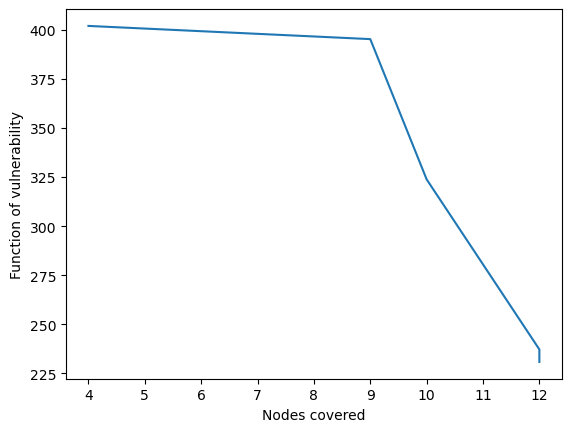

In [14]:
import matplotlib.pyplot as plt
plt.plot(OFc, OFp)
plt.ylabel('Function of vulnerability')
plt.xlabel('Nodes covered')
plt.show()